## PINNs applied to the 1D Schrodiger equation, a walk through

At first, in my first attempt of using PINNs I'll solve the time independent 1D Schrodinger equation:

\begin{equation*}

 -\frac {\hbar^2}{2m} \frac {d^2 \Psi(x,t)}{dx^2} + (V(x)-E) \Psi(x,t) = 0.
\end{equation*}

By Separation of variables, it has the solution:

\begin{equation*}

 \Psi_n(x,t) = \psi_n(x) * \phi_n(t) 
\end{equation*}

with $\phi(t) = e^{-i \frac{E_n*t}{\hbar}}$, we can focus on the spatial coordinate, $\psi_n(x)$. 

Now, the problem depends on the pontential, for simplicity we shall consider the well know infinite square well, of length a:

\begin{equation*}
 V(x) =
  \begin{cases}
  0 & \text{, } 0 \leq x\leq a \\
  \infty & \text{, otherwise }
  \end{cases}
\end{equation*}


With the initial conditions:

$ \psi(0) = 0 = \psi(a)$

Has the following exact solution:

\begin{equation*}

  \psi_n(x)= \sqrt{\frac{2}{a}} sin (\frac{n \pi}{a}x)

\end{equation*}

with n=1,2,3,...

Noting that we set $k= \frac{\sqrt{2mE}}{\hbar}$, thus the initial conditions, that have $k_n=\frac{n \pi}{a} \Rightarrow E_n= \frac{n^2 \pi^2 \hbar^2}{2ma^2}$. Hence, we know the full stationary states:

\begin{equation*}

  \Psi_n(x,t)= \sqrt{\frac{2}{a}} sin (\frac{n \pi}{a}x) e^{-i \frac{n^2 \pi^2 \hbar}{2ma^2}t}

\end{equation*}


Let us first just solve the 1D problem and then worry about time and other dependences :)

In [9]:
#The important packages for this problem: 

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
def Time_Independent_Schrodinger(a, n, x):
    """
    Defines the analytical solution to the time independent 1D Schrodinger equation problem. 
    Parameters: a = Length of box
                n = Energy state, ie n=1 is the ground state, n=2 is the first excited state,...
                x = Position   
    """
    
    pi= np.pi
    psi = np.sqrt(2/a) * np.sin( (n* pi * x) / a) 
    
    return psi

In [11]:
class FCN_TANH(nn.Module):
    "Defines a fully connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

class FCN_GELU(nn.Module):
    "Defines a fully connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.GELU
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


class FCN_RELU(nn.Module):
    "Defines a fully connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.ReLU
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

#Here I intend to check the perfomance of different activations

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


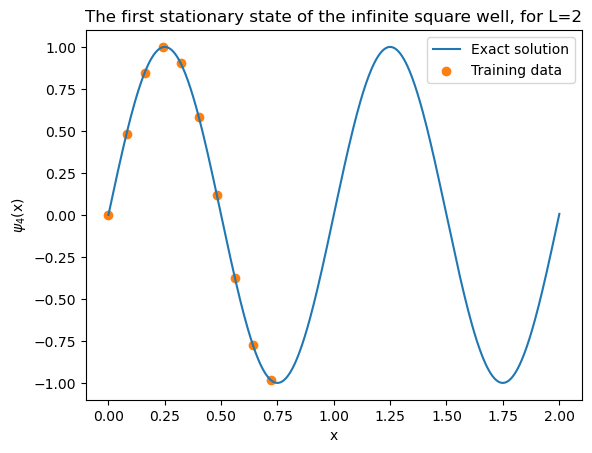

In [12]:
a, n = 2, 4

# get the analytical solution over the full domain
x = torch.linspace(0,a+0.001,500).view(-1,1)
y = Time_Independent_Schrodinger(a, n, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.xlabel("x")
plt.ylabel("$\psi_4$(x)")
plt.title("The first stationary state of the infinite square well, for L=2")
plt.show()

In [13]:
#Function that plots the results:

def plot_result(x,y,x_data,y_data,yh):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    
    l = plt.legend(loc=(1.01,0.34), frameon=True, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlabel("x")
    plt.ylabel("$\psi$(x)")
    plt.title(f"Training step: {i+1}")

In [14]:
#Function that plots the evolution of the loss function(s) over the iterations

def plot_losses(losses1,losses2=None,losses3=None,losses4=None,lossestot=None):
    plt.figure()
    plt.title("Loss over epoch")
    plt.plot(losses1,label="ML Loss")
    if None not in (losses2, losses3, losses4,lossestot):
        plt.plot(losses2,label="Dif Eq loss")
        plt.plot(losses3,label="Boundary 1 loss")
        plt.plot(losses4,label="Boundary 2 loss")
        plt.plot(lossestot,label="Total loss")
    
    plt.legend()
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.show()

 48%|████▊     | 478/1000 [00:03<00:02, 205.63it/s]

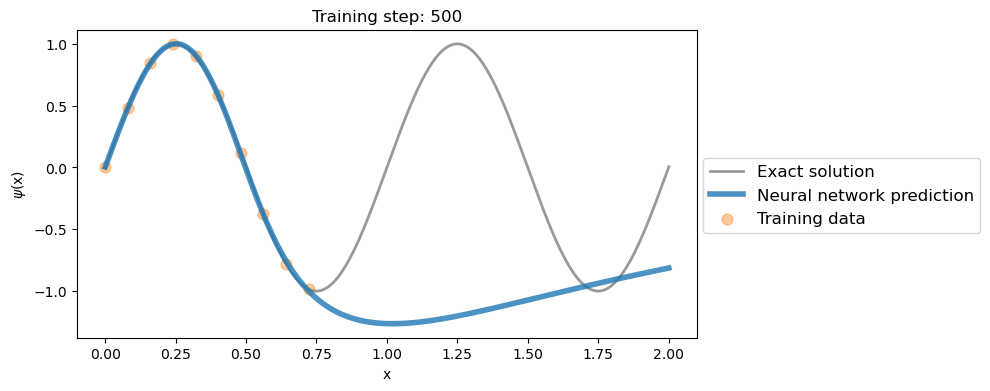

 98%|█████████▊| 980/1000 [00:06<00:00, 166.34it/s]

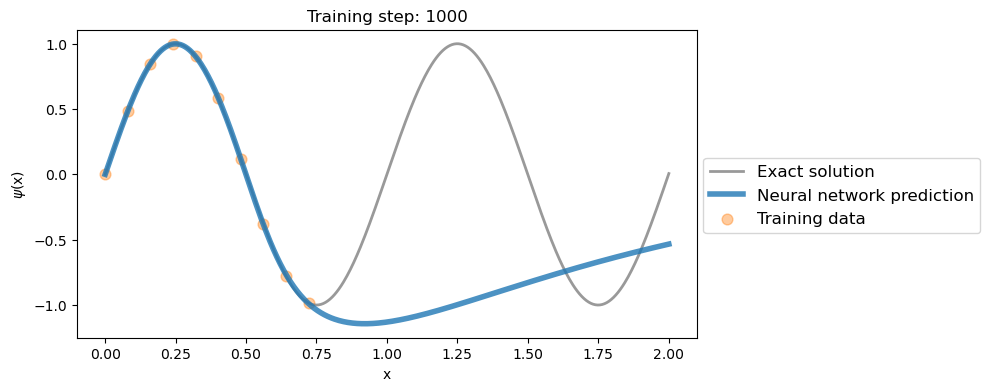

100%|██████████| 1000/1000 [00:07<00:00, 131.89it/s]


In [15]:
# train standard neural network to fit training data - TANH activation for example but it does not converge with any
torch.manual_seed(123)
model = FCN_TANH(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

losses = []

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")


 48%|████▊     | 480/1000 [00:03<00:04, 112.42it/s]

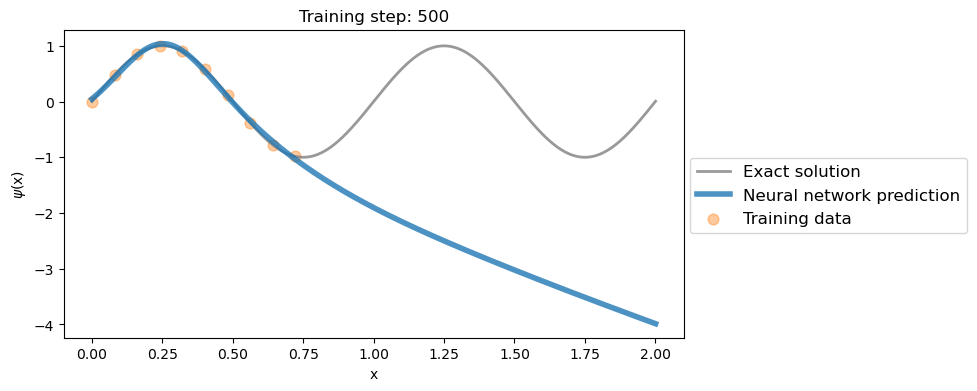

 99%|█████████▉| 994/1000 [00:07<00:00, 207.44it/s]

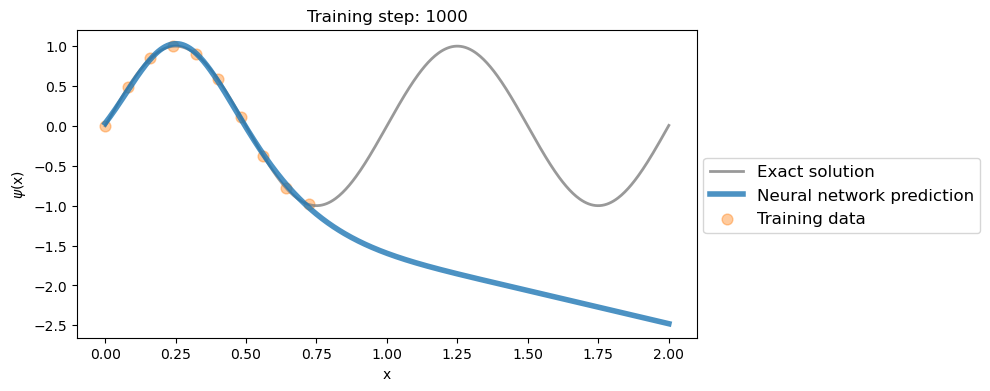

100%|██████████| 1000/1000 [00:07<00:00, 135.02it/s]


In [16]:
# train standard neural network to fit training data - TANH activation for example but it does not converge with any
torch.manual_seed(123)
model = FCN_GELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")


 48%|████▊     | 482/1000 [00:03<00:02, 188.33it/s]

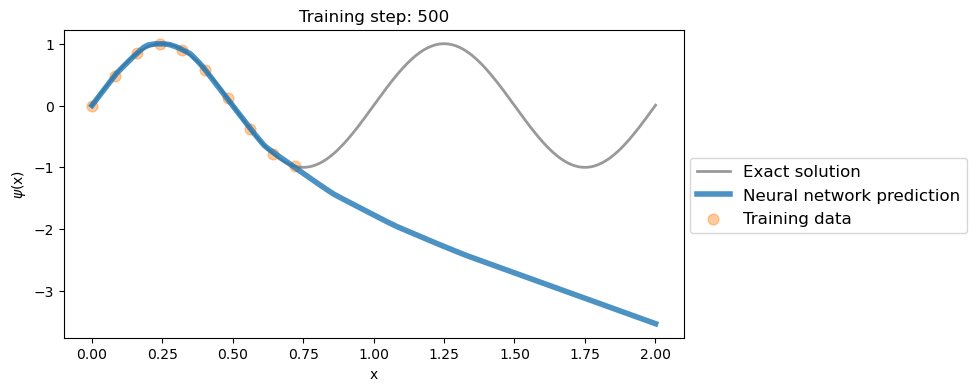

 98%|█████████▊| 980/1000 [00:07<00:00, 138.71it/s]

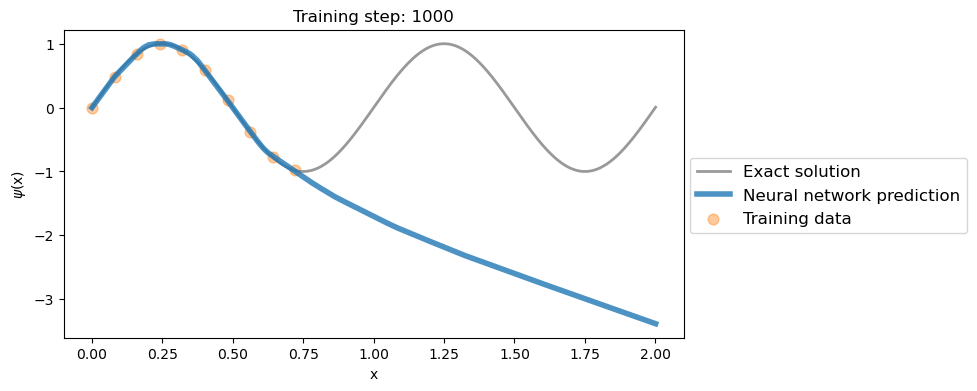

100%|██████████| 1000/1000 [00:07<00:00, 128.88it/s]


In [17]:
# train standard neural network to fit training data - TANH activation for example but it does not converge with any
torch.manual_seed(123)
model = FCN_RELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")


$\textbf{Conclusions}: $

- Not one activation is able to converge !
- All activations seem to take $\approx$ 20 seconds, GeLU and ReLu converge in a similar way 
- The data points we have are not enough for the neural network to predict its behaviour, right?

As a sanity check of the code, one should check that the loss function converges, ie, the computer is doing the best he can and just isn't getting better results because it needed more information!

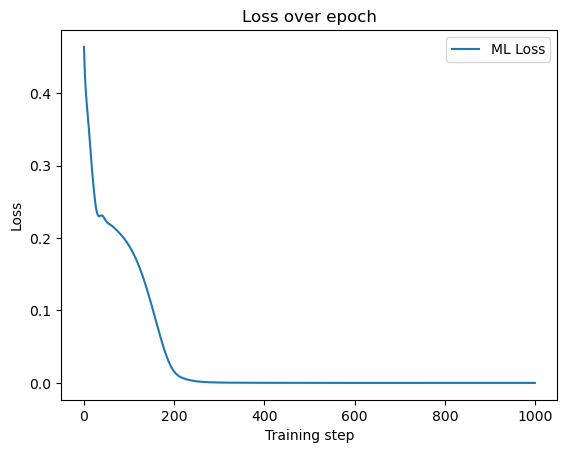

In [18]:
#For instance, the plot for the Tanh activation
plot_losses(losses)

$\textbf{But if we inserted physics into the network?}$

We will define three "Loss functions":

- One that is data driven, typical in ML, that minimizes the distance between the data points and the model of the NN;
- Two that are physics driven:
    - One that takes care of the boundary conditions;
    - One that gives the equation to the network.

We intend to minimize the loss, ie, force the network to respect the differential equation, in this case, the Schrodinger Equation, the Boundary Conditions and of course, let the black box do what it does best.

One very important thing to note is:
Loss $\neq$ Loss_1 + Loss_2 + Loss_3

One has to take into account the order of magnitude of each "Loss function" and balance it out, meaning: 

\begin{equation*}
    Loss = \lambda_1 Loss_1 + \lambda_2 Loss_2 + \lambda_3 Loss_3 + \lambda_4 Loss_4 
\end{equation*}


In [19]:
# sample locations over the problem domain
x_physics = torch.linspace(0,2,30).view(-1,1).requires_grad_(True)

# define boundary points, for the boundary loss
t_boundary1 = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary2 = torch.tensor(2.).view(-1,1).requires_grad_(True)


#set your constantes
hbar = 1 
m = 1

#Define your differential equations terms
E = (n * np.pi * hbar) **2 / (2*m*a**2)
k_squared= (2*m*E) / (hbar**2)

########################

#Define the hyperparameters lambda:
lambda1 = 1 
lambda2 = 1e-4
lambda3 = 1
lambda4 = 1e-1

 50%|████▉     | 4992/10000 [00:25<00:20, 245.91it/s]

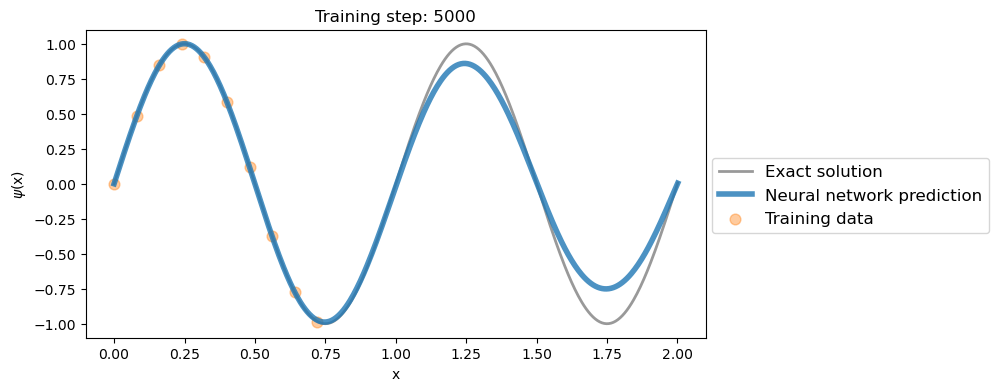

100%|█████████▉| 9998/10000 [00:50<00:00, 194.49it/s]

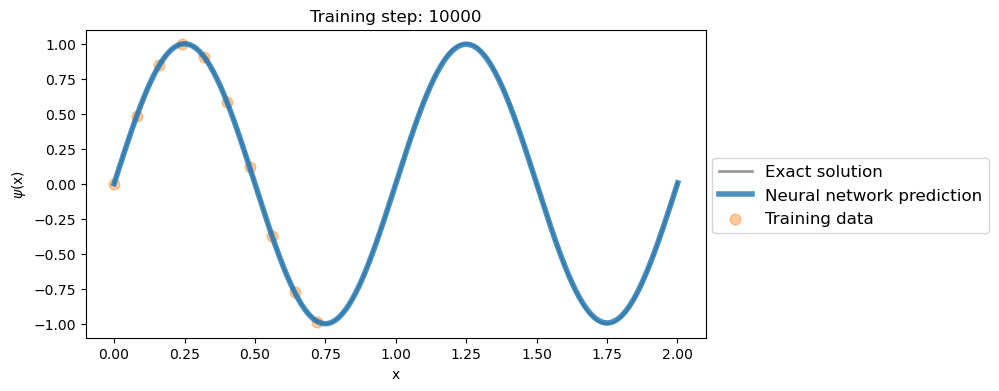

100%|██████████| 10000/10000 [00:51<00:00, 195.95it/s]


In [20]:
#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN_TANH(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []

for i in tqdm(range(10000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    
    # Equation: 
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the 1D time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward()
    optimizer.step()

    losses1.append(loss1.detach())
    losses2.append(loss2.detach())
    losses3.append(loss3.detach())
    losses4.append(loss4.detach())
    lossestot.append(loss.detach())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")
            


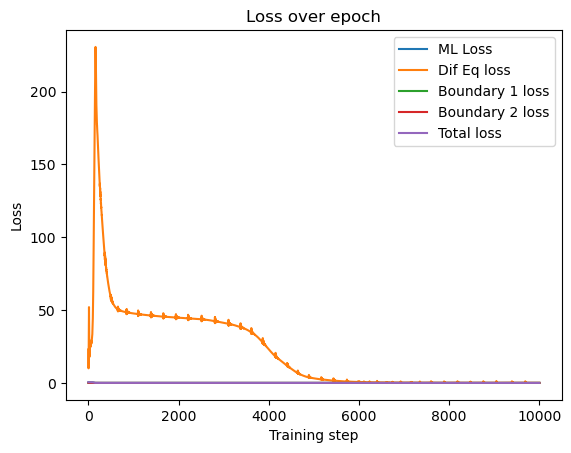

In [21]:
plot_losses(losses1,losses2,losses3, losses4, lossestot)

 50%|████▉     | 4995/10000 [00:39<00:59, 84.25it/s] 

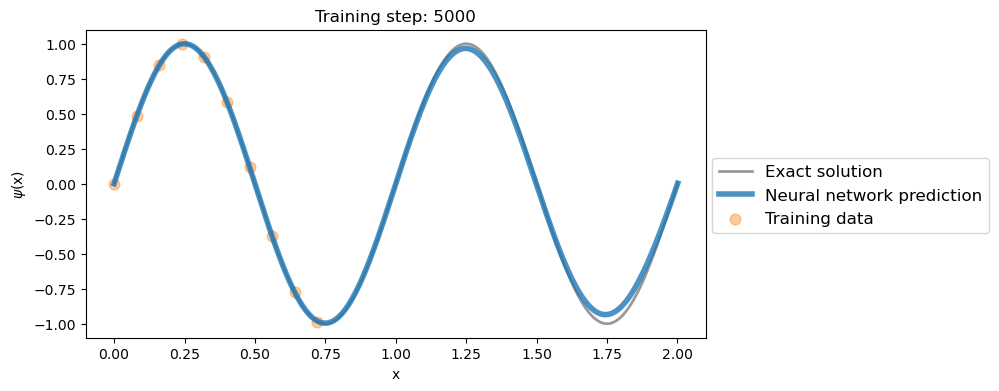

100%|█████████▉| 9998/10000 [01:17<00:00, 155.30it/s]

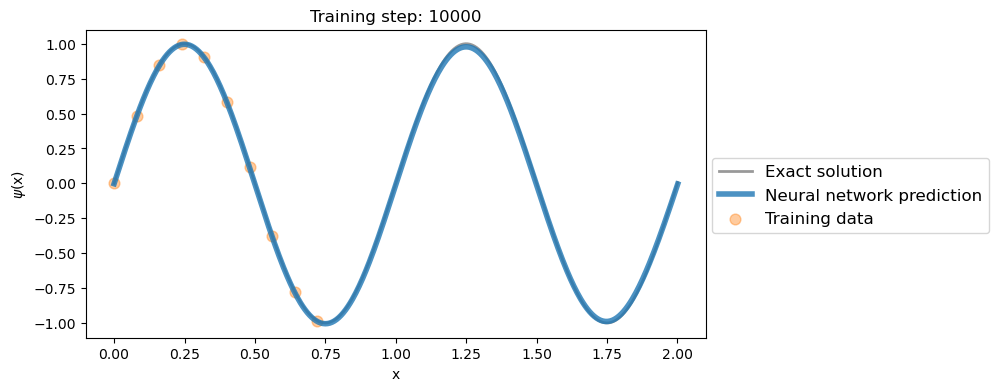

100%|██████████| 10000/10000 [01:17<00:00, 129.11it/s]


In [22]:
#Same but with GELU 

#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN_GELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []

for i in tqdm(range(10000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    
    # Equation: 
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the 1D time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward()
    optimizer.step()

    losses1.append(loss1.detach())
    losses2.append(loss2.detach())
    losses3.append(loss3.detach())
    losses4.append(loss4.detach())
    lossestot.append(loss.detach())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")
            


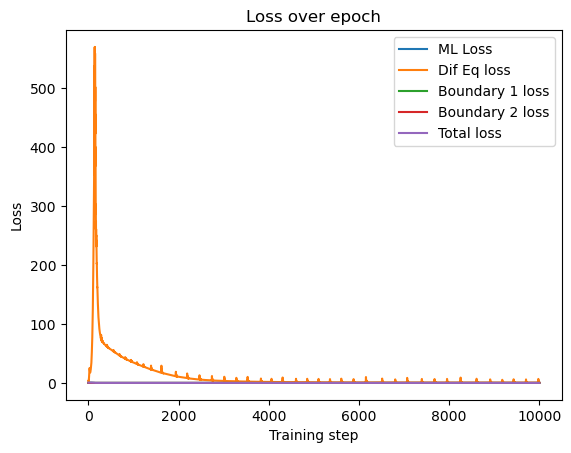

In [23]:
plot_losses(losses1,losses2,losses3, losses4, lossestot)

 50%|████▉     | 4994/10000 [00:20<00:28, 177.02it/s]

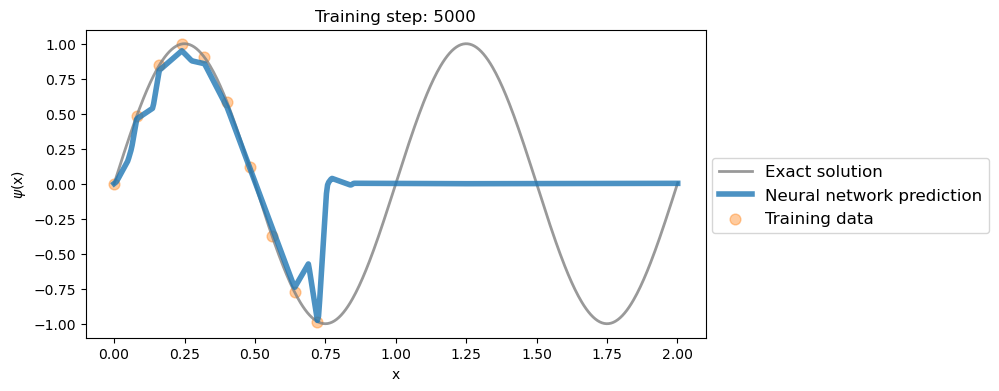

100%|█████████▉| 9999/10000 [00:55<00:00, 166.87it/s]

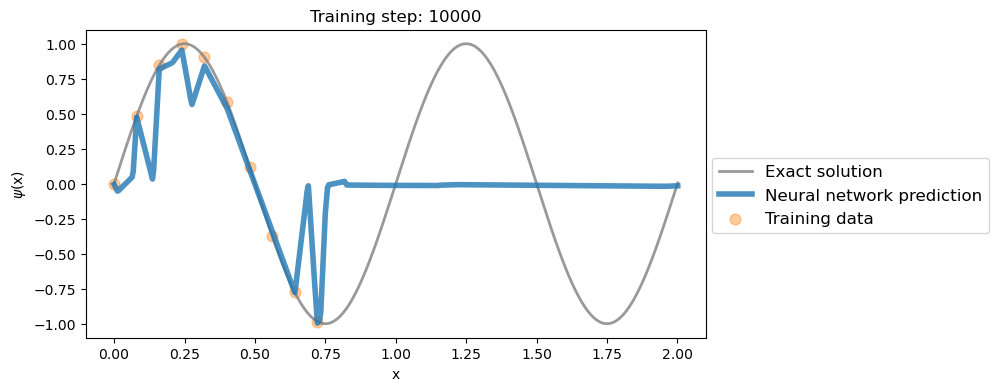

100%|██████████| 10000/10000 [00:56<00:00, 176.55it/s]


In [24]:
#Same but with RELU

#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN_RELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for i in tqdm(range(10000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    
    # Equation: 
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the 1D time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")
            


Conclusions:

- Tanh is definitely faster!
- Gelu seems to convert faster!
- Relu seems weird

# Bohr potential

The radial equation for the Bohr potential:
\begin{equation*}
    V(r)= -\frac{e^2}{4 \pi \epsilon_0} \frac{1}{r}
\end{equation*}
is:
\begin{equation*}
    -\frac {\hbar^2}{2m} \frac {d^2 u}{dr^2} + \left( -\frac{e^2}{4 \pi \epsilon_0} \frac{1}{r}+ \frac{\hbar^2}{2m}\frac{l(l+1)}{r^2} - E \right) u(r) = 0 
\end{equation*}

We will skip the details (for now?) but once again it has a solution:

\begin{equation*}
\Psi(r,\theta, \phi) = \R(r) Y(\theta,\phi)
\end{equation*}

the $Y(\theta,\phi)$ are the spherical harmonics. Gladly python has a [function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html) that calculates this for us :).Y depends on two integers, l that is called the azimuthal quantum number and m the magnetic quantum number, these are physical quantities that are related with the angular momentum of the electron. We also have n, the principal quantum number: it tells you the energy of the electron. All this will be important briefly.

The radial solution is:

\begin{equation*}
R_{nl}(r) = \sqrt{\left(\frac{2}{n a}\right)^3 \frac{(n-\ell-1) !}{2 n(n+\ell) !}} e^{-r / n a}\left(\frac{2 r}{n a}\right)^{\ell}\left[L_{n-\ell-1}^{2 \ell+1}(2 r / n a)\right]
\end{equation*}

with a,the Bohr radius, $a=0.529 × 10^{−10} m$, and $L_q^p (x)$ are the associated [Laguerre polynomials](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.assoc_laguerre.html). 
with 

Although not pretty the full solution is:
$$
\psi_{n \ell m}=\sqrt{\left(\frac{2}{n a}\right)^3 \frac{(n-\ell-1) !}{2 n(n+\ell) !}} e^{-r / n a}\left(\frac{2 r}{n a}\right)^{\ell}\left[L_{n-\ell-1}^{2 \ell+1}(2 r / n a)\right] Y_{\ell}^m(\theta, \phi)
$$

Defining $\rho$ as $\frac{r}{na}$ :

$$
\psi_{n \ell m}=\sqrt{\left(\frac{2}{n a}\right)^3 \frac{(n-\ell-1) !}{2 n(n+\ell) !}} e^{-\rho }\left(2 \rho\right)^{\ell}\left[L_{n-\ell-1}^{2 \ell+1}(2 \rho)\right] Y_{\ell}^m(\theta, \phi)
$$


As Griffiths said: don't complain! This is one of the very few realistic systems that can be solved at all, in exact closed form.

Now we will solve the same task but with a different function to clarify how good can PINNs be.

In [25]:
# lets plot the radial solution: 


def Bohr_3D(l,n,r,a):
    """
    Defines the analytical solution to the time independent 1D Schrodinger equation problem. 
    Parameters: l = azimuthal quantum number
                n = Principal quantum number
                r = Radial postion.   
    """
    
    rho= r / (a*n) 
    normalization = np.sqrt( (2/(n*a))**3 * ( np.math.factorial(n-l-1)) / (2*n* np.math.factorial(n+l)))

    psi = normalization * np.exp(-rho)* (2*rho)**(l) * assoc_laguerre(2*rho, n-l-1 ,2*l+1 )
    
    return psi

torch.Size([10, 1]) torch.Size([10, 1])


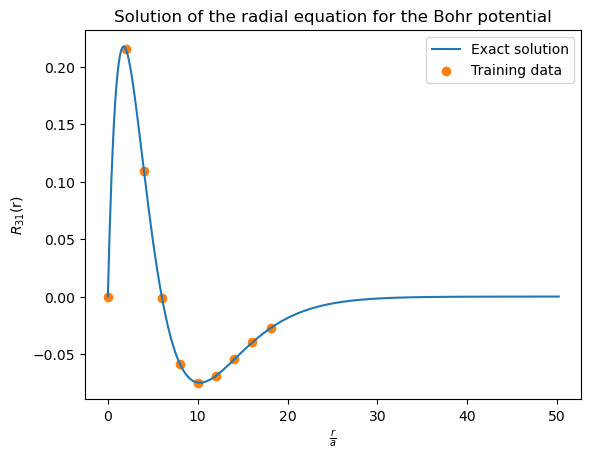

In [26]:
#special functions:
from scipy.special import assoc_laguerre

# Plot of the exact radial solution and extracting the training points

n, l = 3, 1

#a = 0.529* (10**(-10)) #Bohr Radius in meters
a = 0.529 #Bohr Radius in Angstrom  

# get the analytical solution over the full domain
r = torch.linspace(0,(50*a)+0.1,500).view(-1,1)
wave = Bohr_3D(l, n, r, a).view(-1,1)

# slice out a small number of points from the LHS of the domain
x_data = r[0:200:20]
y_data = wave[0:200:20]
print(x_data.shape, y_data.shape)

#Here I purposefully defined the training data to look like this to be "hard" for the NN to guess the output 

plt.figure()
plt.plot(r/a, wave , label="Exact solution")
plt.scatter(x_data/a, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.xlabel("$\\frac{r}{a}$")
plt.ylabel(f"$R_{{31}}$(r)") #If you change n,l please change them here
plt.title("Solution of the radial equation for the Bohr potential")
plt.show()

In [27]:
# Note that it is important to let the wave converge!

wave[len(wave)-1]

tensor([-6.3042e-06], dtype=torch.float64)

In [28]:
# sample locations over the problem domain
x_physics = torch.linspace(0.01,50,50).view(-1,1).requires_grad_(True)

# define boundary points, for the boundary loss
t_boundary1 = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary2 = torch.tensor(26.5).view(-1,1).requires_grad_(True)



#set constantes
hbar = 1 
m_e = 1
epsilon_0 = 1
e = 1 

#set terms of equation
Bohr_term = (m_e * e**2) / (2*np.pi * epsilon_0 * x_physics * (hbar**2))
k_squared = (a*n)**(-2)
l_term = l*(l+1) / (x_physics**2)


########################

#Define the hyperparameters lambda:
lambda1 = 1 
lambda2 = 1e-9
lambda3 = 1
lambda4 = 1e-1


 25%|██▍       | 4999/20000 [00:55<02:15, 110.89it/s]

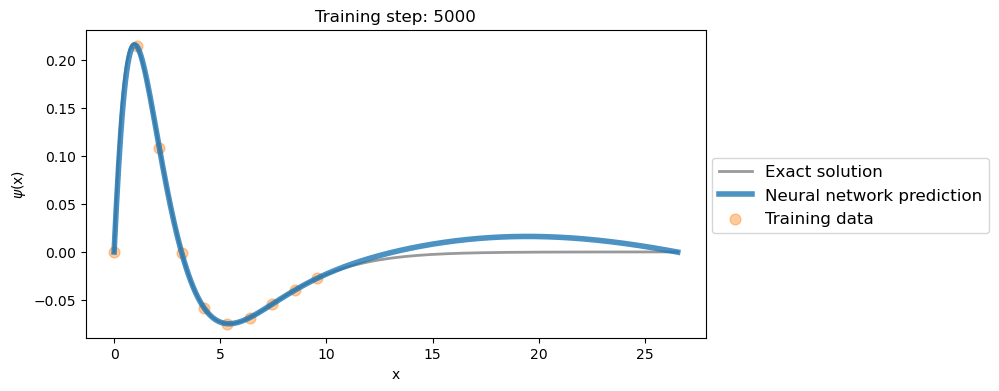

 50%|████▉     | 9999/20000 [01:46<01:31, 109.20it/s]

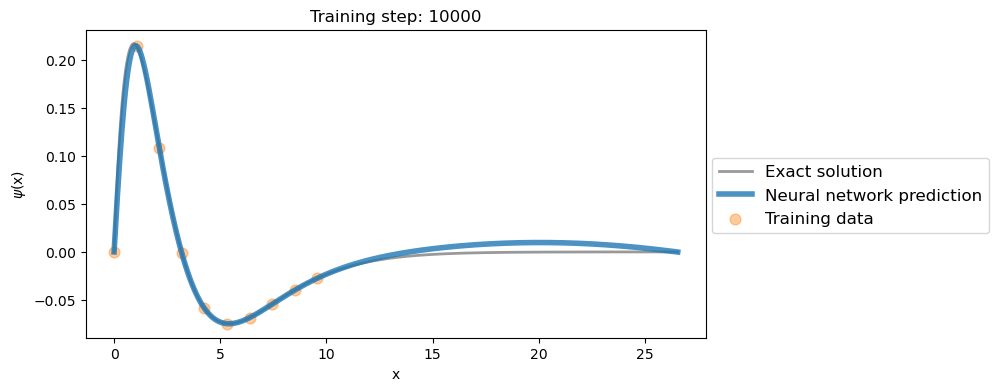

 75%|███████▍  | 14989/20000 [02:28<00:50, 98.70it/s] 

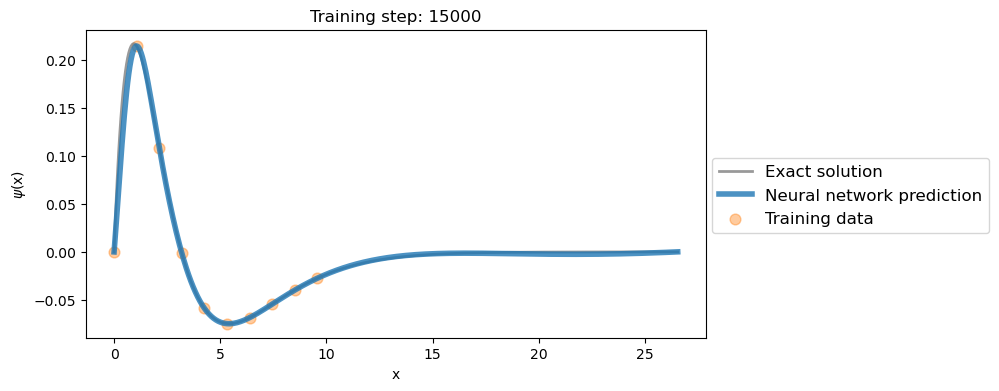

100%|█████████▉| 19990/20000 [03:00<00:00, 174.00it/s]

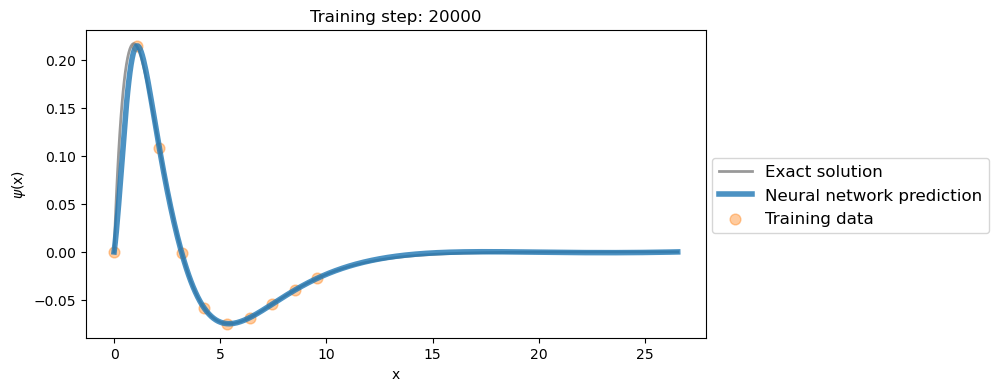

100%|██████████| 20000/20000 [03:01<00:00, 110.39it/s]


In [29]:
#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN_GELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []

for i in tqdm(range(20000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
        
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + (-k_squared+Bohr_term-l_term)*yhp # computes the residual of the 3D time independent radial Schrodinger differential equation with Bohr potential
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward(retain_graph=True)
    optimizer.step()

    losses1.append(loss1.detach())
    losses2.append(loss2.detach())
    losses3.append(loss3.detach())
    losses4.append(loss4.detach())
    lossestot.append(loss.detach())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(r).detach()
        xp = x_physics.detach()
        
        plot_result(r,wave,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")



Still with the Bohr potential, as a code sanity check, we will observe if PINNs are able to converge with another data points. Also as a code sanity check, we will use other quantum numbers (n,l,m)

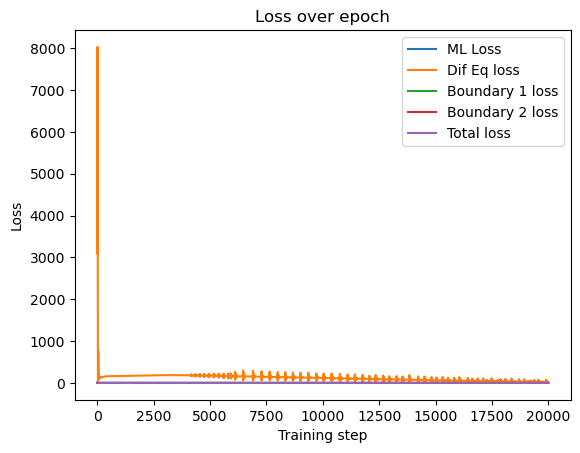

In [30]:
plot_losses(losses1,losses2,losses3,losses4,lossestot)

torch.Size([10, 1]) torch.Size([10, 1])


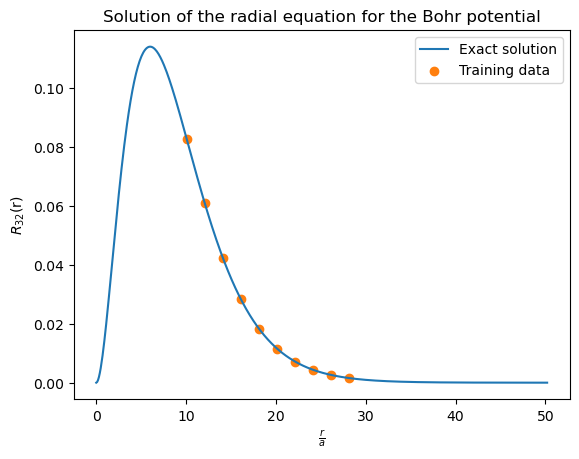

In [31]:

# Plot of the exact radial solution and extracting the training points

n, l = 3, 2

wave = Bohr_3D(l, n, r, a).view(-1,1)

# slice out a small number of points from the LHS of the domain
x_data = r[100:300:20]
y_data = wave[100:300:20]
print(x_data.shape, y_data.shape)

#Here I purposefully defined the training data to look like this to be "hard" for the NN to guess the output 

plt.figure()
plt.plot(r/a, wave , label="Exact solution")
plt.scatter(x_data/a, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.xlabel("$\\frac{r}{a}$")
plt.ylabel(f"$R_{{32}}$(r)") #If you change n,l please change them here
plt.title("Solution of the radial equation for the Bohr potential")
plt.show()

In [32]:
wave[len(wave)-1]

tensor([3.2022e-06], dtype=torch.float64)

 25%|██▍       | 4989/20000 [00:49<02:21, 105.74it/s]

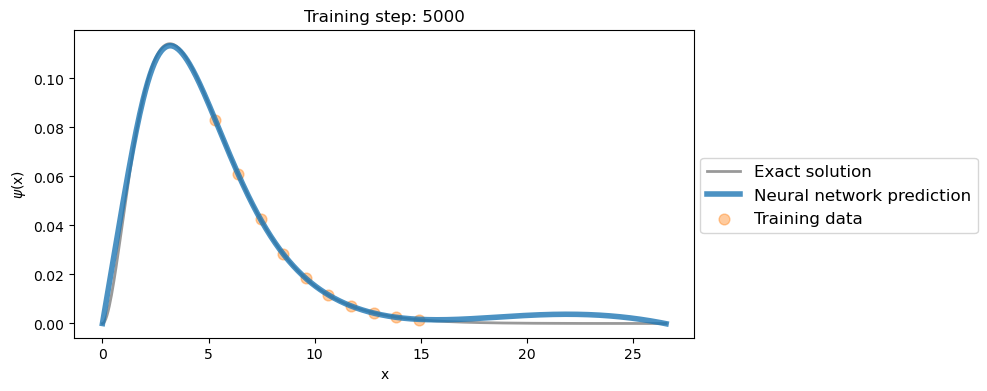

 50%|████▉     | 9987/20000 [01:45<01:29, 112.07it/s]

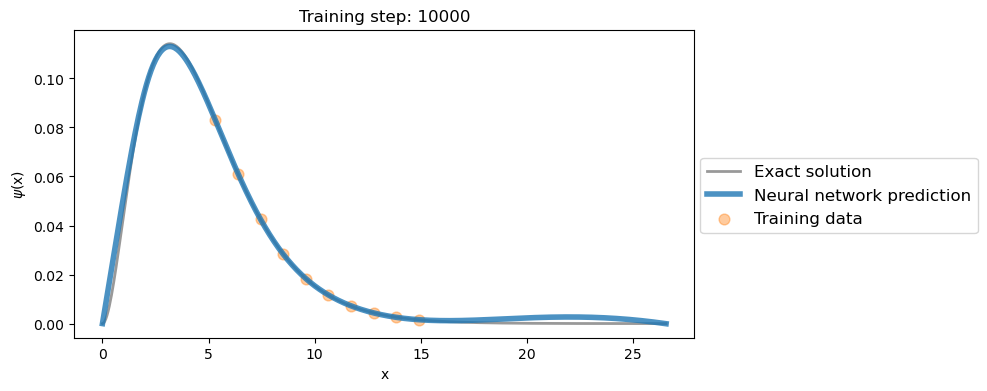

 75%|███████▍  | 14990/20000 [02:30<00:43, 114.72it/s]

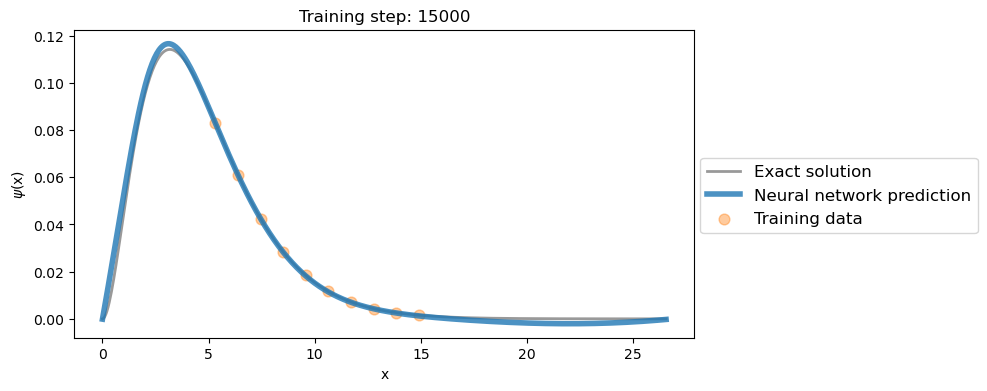

100%|█████████▉| 19996/20000 [03:17<00:00, 107.54it/s]

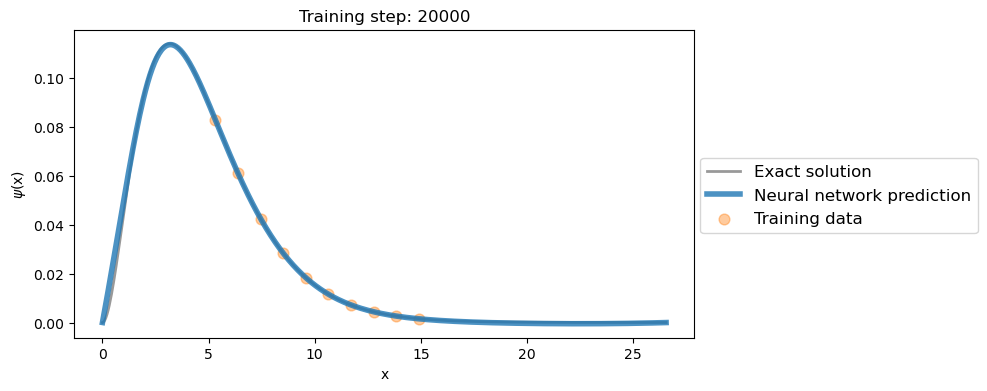

100%|██████████| 20000/20000 [03:17<00:00, 101.12it/s]


In [33]:
#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN_GELU(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

lambda2= 1e-12

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []


for i in tqdm(range(20000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
        
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + (-k_squared+Bohr_term-l_term)*yhp # computes the residual of the 3D time independent radial Schrodinger differential equation with Bohr potential
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward(retain_graph=True)
    optimizer.step()

    losses1.append(loss1.detach())
    losses2.append(loss2.detach())
    losses3.append(loss3.detach())
    losses4.append(loss4.detach())
    lossestot.append(loss.detach())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(r).detach()
        xp = x_physics.detach()
        
        plot_result(r,wave,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")

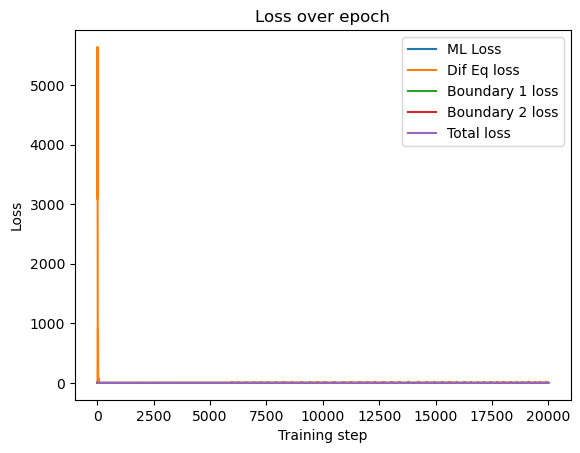

In [28]:
plot_losses(losses1,losses2,losses3,losses4,lossestot)